<a href="https://colab.research.google.com/github/JNPauli/Protect_app_master_thesis/blob/main/Natural_image_Classification_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. This notebook is the continuation to the preprocessing.ipynb notebook.

1. Import all neccessary modules 

In [26]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import gc
from torch.utils.data import random_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Import X and y

In [3]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [4]:
os.chdir('/content/drive/MyDrive/Thesis')

In [5]:
y = np.load('train_con.npy')
y_idx = pd.read_csv('idx_y.csv')

Remove elements from y that were not RBG but grayscale by index

In [6]:
y = y[0:10001]

In [7]:
y_ = np.delete(y,y_idx.iloc[:,1],axis=0)

In [8]:
y_.shape

(9976, 3)

NEW APPROACH:

Fit CNN on orginal images, so no salience maps

1. Read `n-rows`from X.

In [9]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [10]:
X = np.load('mscoco_og.npy')

In [11]:
X = np.swapaxes(X,0,3)

In [12]:
X = np.swapaxes(X,1,3)

In [13]:
X.shape

(9976, 3, 224, 224)

In [14]:
X_ = torch.from_numpy(X).to(device)

In [18]:
y_ = torch.from_numpy(y_).to(device)

In [16]:
del X
gc.collect()

153

Converting X to appropriate Datatype...

In [19]:
X_ = torch.tensor(X_,dtype = torch.float32)

y_ = y_.type(torch.LongTensor)

<ipython-input-19-e30e4ab0470a>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_ = torch.tensor(X_,dtype = torch.float32)


To get max value of classN-1

In [20]:
y_ = y_-1

In [21]:
X_.to('cpu');

tensor([[[[0.7020, 0.6981, 0.7073,  ..., 0.8767, 0.8867, 0.8576],
          [0.6986, 0.7020, 0.7073,  ..., 0.8747, 0.8612, 0.8522],
          [0.6954, 0.7020, 0.7113,  ..., 0.8611, 0.8552, 0.8436],
          ...,
          [0.5658, 0.5406, 0.3496,  ..., 0.8820, 0.8859, 0.8862],
          [0.5381, 0.5430, 0.5626,  ..., 0.8720, 0.8712, 0.8645],
          [0.6561, 0.2843, 0.4027,  ..., 0.8772, 0.8746, 0.8690]],

         [[0.8667, 0.8628, 0.8694,  ..., 0.8532, 0.8631, 0.8419],
          [0.8633, 0.8667, 0.8694,  ..., 0.8512, 0.8443, 0.8366],
          [0.8601, 0.8667, 0.8733,  ..., 0.8454, 0.8395, 0.8333],
          ...,
          [0.5533, 0.5459, 0.3829,  ..., 0.8507, 0.8545, 0.8548],
          [0.5781, 0.5818, 0.6122,  ..., 0.8563, 0.8555, 0.8488],
          [0.6865, 0.3080, 0.4461,  ..., 0.8616, 0.8589, 0.8533]],

         [[0.9529, 0.9491, 0.9556,  ..., 0.8061, 0.8161, 0.7949],
          [0.9496, 0.9529, 0.9556,  ..., 0.8041, 0.7972, 0.7895],
          [0.9464, 0.9530, 0.9596,  ..., 0

Setup custom dataset class

In [22]:
class SimpleDataset(Dataset):
    def __init__(self, X, y,transform=None):
        self.X = X
        self.y = y
        self.transform = transforms.Compose([transforms.Normalize(torch.mean(X), torch.std(X))])
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
          X = self.transform(X)
 
        return X, y

In [23]:
dataset = SimpleDataset(X_,y_,transform=True)

In [24]:
print("length of the dataset is:", len(dataset))

length of the dataset is: 9976


In [28]:
train_data, test_data = random_split(dataset, [7000, 2976])

In [40]:
dataloader_train = DataLoader(train_data, batch_size=32, shuffle=True) 
dataloader_val = DataLoader(test_data, batch_size=32, shuffle=True) 

Setting up the CNN.

In [42]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.batch = nn.BatchNorm2d(32)
        #self.conv2 = nn.Conv2d(32,64,3) #remove layer
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(394272, 128)
        #self.fc2 = nn.Linear(128,10)
        self.Arousal = nn.Linear(128,10) #3
        self.Valence = nn.Linear(128,10)
        self.Dominance = nn.Linear(128,10)
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch(x)
        x = F.relu(x)
        #x = self.conv2(x)
        #x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        #x = self.fc2(x)
        Arousal = self.Arousal(x)
        Valence = self.Valence(x)
        Dominance = self.Dominance(x)
        return Arousal, Valence, Dominance 
#removed 

In [ ]:
SalienceNet = CNN()
#SalienceNet.to(device)

In [ ]:
class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2 
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()

In [ ]:
cont_loss = ContinuousLoss_L2()

In [29]:
criterion = nn.CrossEntropyLoss()

In [60]:
from tqdm import tqdm
def train(net, loss_fn, dataloader_train,dataloader_val,
          epoch=100, learning_rate=0.0001):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)#torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-4) # weight decay as a regularization technique to defy overfitting
    for param in model_CNN.parameters():
        param.requires_grad = False
    for param in model_CNN.Arousal.parameters():
      param.requires_grad = True
    for param in model_CNN.Valence.parameters():
      param.requires_grad = True
    for param in model_CNN.Dominance.parameters():
      param.requires_grad = True
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    train_epoch_loss = []
    val_epoch_loss = []
    for i in range(epoch):
        train_loop = tqdm(dataloader_train)
        val_loop = tqdm(dataloader_val)
        total = 0
        correct_a,correct_v,correct_d=0,0,0
        net.to(device)   
        net.train()
        for data, label in train_loop:
            data, label = data.to(device), label.to(device)
            #make prediction
            Arousal,Valence,Dominance = net(data.float())

            _a, y_pred_train_arousal = torch.max(Arousal,1)
            _v, y_pred_train_valence = torch.max(Valence,1)
            _d, y_pred_train_dominance = torch.max(Dominance,1)

            total += label[:,0].size(0)+label[:,1].size(0)+label[:,2].size(0)

            correct_a += (y_pred_train_arousal == label[:,0]).sum().item()
            correct_v += (y_pred_train_valence == label[:,1]).sum().item()
            correct_d += (y_pred_train_dominance == label[:,2]).sum().item()
           
            sum_correct = (correct_a+correct_v+correct_d)
            # Zero out the gradients
            optimizer.zero_grad()

            # Calculate loss.
            #loss = loss_fn(output,label)#torch.max(label.long(), 1)[0])
            loss_arousal = loss_fn(Arousal,label[:,0])
            loss_valence = loss_fn(Valence,label[:,1])
            loss_dominance = loss_fn(Dominance,label[:,2])
            loss=loss_arousal+loss_valence+loss_dominance

      
            # Backpropagation and gradient update.
            loss.backward()# Calculate gradients. #retrain_graph=True

            optimizer.step() # Apply gradient update
            
            train_loss.append(loss.item())
            train_loop.set_description(f"Epoch [{i+1}/{epoch}]")

        train_accuracy.append(sum_correct/total)
        train_epoch_loss.append((np.array(train_loss).mean()))

        #validation
        net.eval()
        val_total = 0
        val_arousal,val_valence, val_dominance = 0,0,0
        for data, labels in dataloader_val:
            data, labels = data.to(device), labels.to(device)

            Arousal_v,Valence_v,Dominance_v = net(data.float())

            _a, y_pred_val_arousal = torch.max(Arousal_v,1)
            _v, y_pred_val_valence = torch.max(Valence_v,1)
            _d, y_pred_val_dominance = torch.max(Dominance_v,1)

            val_total += labels[:,0].size(0)+labels[:,1].size(0)+labels[:,2].size(0)

            val_arousal += (y_pred_val_arousal == labels[:,0]).sum().item()
            val_valence += (y_pred_val_valence == labels[:,1]).sum().item()
            val_dominance += (y_pred_val_dominance == labels[:,2]).sum().item()
           
            sum_correct_val = (val_arousal+val_valence+val_dominance)
          
            loss_arousal_v = loss_fn(Arousal_v,labels[:,0])
            loss_valence_v = loss_fn(Valence_v,labels[:,1])
            loss_dominance_v = loss_fn(Dominance_v,labels[:,2])

            val_l=loss_arousal_v+loss_valence_v+loss_dominance_v
        
            val_loss.append(val_l.item())

        val_epoch_loss.append((np.array(val_loss).mean()))

        val_accuracy.append(sum_correct_val/val_total)


    return train_loss,train_epoch_loss,val_loss,val_epoch_loss, train_accuracy,val_accuracy


In [31]:
def test(net,loss_fn,dataloader_test):
  net.eval()
  test_loss = []
  test_total,test_correct = 0,0
  test_acc = []
  test_loop = tqdm(dataloader_test)
  i=0
  for batch, (data, labels) in enumerate(test_loop):
      print('testing...')

      data, labels = data.to(device), labels.to(device)
      arousal,valence,dominance = net(data.float())

      arousal_t = loss_fn(arousal,labels[:,0])
      valence_t = loss_fn(valence,labels[:,1])
      dominance_t = loss_fn(dominance,labels[:,2])

      test_l = arousal_t+valence_t+dominance_t

      test_loss.append(test_l.item())
      test_loop.set_description(f"Batch [{i+1}/{batch}]")
      i=+1

        #test_total += labels.size(0)
        #test_correct += (y_pred_test==torch.max(labels,1)[0]).sum().item()
        
    #test_acc.append(test_correct/test_total)
    #y_pred_test = torch.softmax(outputs,dim=1).argmax(dim=1)

   # print('test acc is {}'.format(test_acc)
  return test_loss

In [32]:
import matplotlib.pyplot as plt

In [33]:
from IPython.display import Javascript

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})''')) 

<IPython.core.display.Javascript object>

In [34]:
from torchvision import models

In [35]:
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 64.9MB/s]


In [36]:
class CNN1(nn.Module):
    def __init__(self, pretrained):
        super(CNN1, self).__init__()
        if pretrained is True:
            self.model = models.__dict__["alexnet"](pretrained="imagenet")
        else:
            self.model = models.__dict__["alexnet"](pretrained=None)
        self.Arousal= nn.Linear(256, 10)
        self.Valence = nn.Linear(256,10)
        self.Dominance = nn.Linear(256, 10)    
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        Arousal = self.Arousal(x)
        Valence = self.Valence(x)
        Dominance = self.Dominance(x)
        return Arousal, Valence, Dominance 
        return {'label1': label1, 'label2': label2, 'label3': label3}

In [37]:
torch.cuda.empty_cache()

In [38]:
model_CNN = CNN1(True).to(device)

In [39]:
for param in model_CNN.parameters():
        param.requires_grad = False
for param in model_CNN.Arousal.parameters():
  param.requires_grad = True
for param in model_CNN.Valence.parameters():
  param.requires_grad = True
for param in model_CNN.Dominance.parameters():
  param.requires_grad = True

In [61]:
np.random.seed(1)
torch.manual_seed(1)

train_loss,train_epoch_loss,val_loss,val_epoch_loss,train_acc,val_acc=train(net=model_CNN,loss_fn=criterion,dataloader_train=dataloader_train,
                  dataloader_val=dataloader_val,epoch=10)




  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]


  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]


  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]


  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]


  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]


  0%|          | 0/93 [00:05<?, ?it/s]


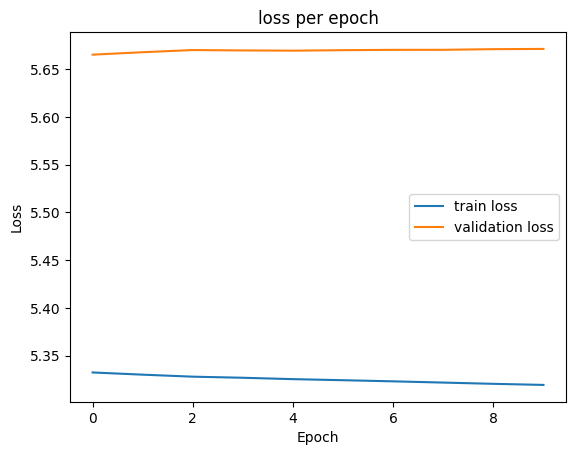

In [65]:
plt.plot(train_epoch_loss, label = 'train loss')
plt.plot(val_epoch_loss, label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('loss per epoch')
plt.legend()
plt.show()

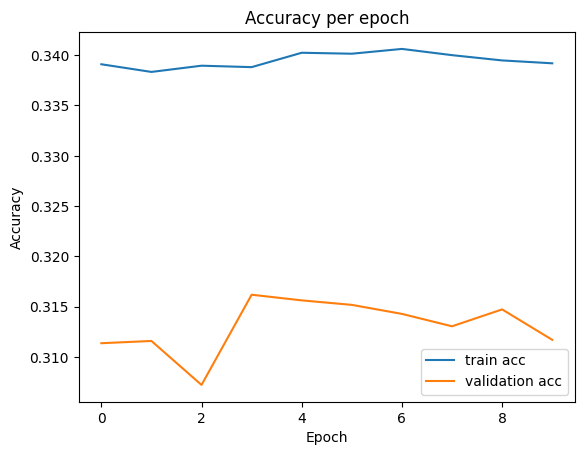

In [64]:
plt.plot(train_acc, label = 'train acc')
plt.plot(val_acc, label = 'validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch')
plt.legend()
plt.show()

In [ ]:
test_loss = test(net=SalienceNet,loss_fn=criterion,dataloader_test=dataloader_test)

In [ ]:
plt.plot(test_loss)
plt.xlabel('Iterations of gradient descent')
plt.ylabel('Loss')
plt.title('Loss for test data')
plt.show()